In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from sklearn.model_selection import train_test_split
from bart_playground import *

In [3]:
# Generate synthetic data with known noise level
import numpy as np
np.random.seed(42)

def generate_synthetic_data(n_samples=10000, noise_std=0.5):
    # Generate input features
    X = np.random.uniform(-1.5, 1.5, (n_samples, 5))
    
    # Create a non-linear function
    # f(x) = 2*sin(2*x1) + x2^2 + 0.5*x1*x3 + x3
    true_f = (2 * np.sin(2 * X[:, 0]) + 
              X[:, 1]**2 + 
              0.5 * X[:, 0] * X[:, 2] + 
              X[:, 2])
    
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, n_samples)
    y = true_f + noise
    
    true_sigma2 = noise_std**2
    return X, y, true_sigma2

# Generate data
noise_std = 0.5  # Standard deviation
true_sigma2 = noise_std**2  # True variance = 0.25
print(f"True noise variance (sigma2): {true_sigma2:.4f}")

X, y, true_var = generate_synthetic_data(n_samples=400, noise_std=noise_std)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

True noise variance (sigma2): 0.2500


In [4]:
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
bart_mtmh = MultiBART(ndpost=500, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10)
bart_mtmh.fit(X_train, y_train)
sigmas_mtmh = [trace.global_params['eps_sigma2'] for trace in bart_mtmh.sampler.trace]
means_mtmh = [trace.evaluate(X_train).mean() for trace in bart_mtmh.sampler.trace]
first_preds_mtmh = [trace.evaluate(X_train[0:1])[0] for trace in bart_mtmh.sampler.trace]

Iterations: 100%|██████████| 500/500 [00:18<00:00, 27.71it/s]


In [5]:
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
bart_default = DefaultBART(ndpost=500, nskip=0, n_trees=100, proposal_probs=proposal_probs)
bart_default.fit(X_train, y_train)
sigmas_default = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
means_default = [trace.evaluate(X_train).mean() for trace in bart_default.sampler.trace]
first_preds_default = [trace.evaluate(X_train[0:1])[0] for trace in bart_default.sampler.trace]

Iterations: 100%|██████████| 500/500 [00:02<00:00, 218.63it/s]


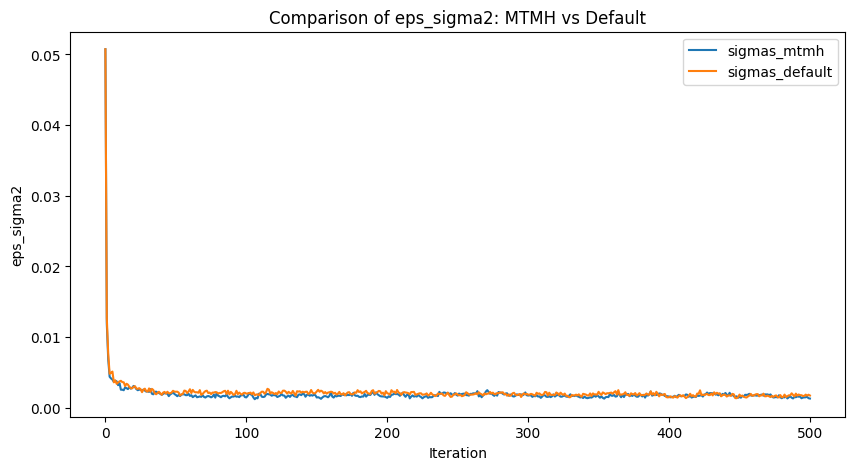

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(sigmas_mtmh, label='sigmas_mtmh')
plt.plot(sigmas_default, label='sigmas_default')
plt.xlabel('Iteration')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Comparison of eps_sigma2: MTMH vs Default')
plt.show()

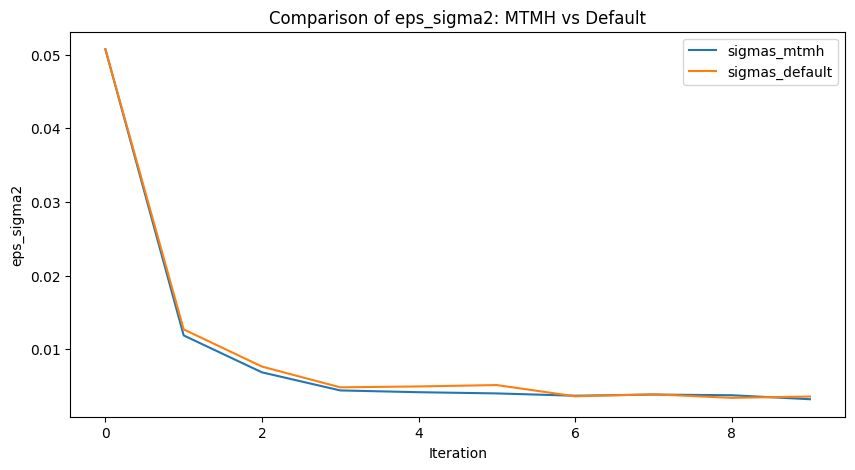

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(sigmas_mtmh[:10], label='sigmas_mtmh')
plt.plot(sigmas_default[:10], label='sigmas_default')
plt.xlabel('Iteration')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Comparison of eps_sigma2: MTMH vs Default')
plt.show()

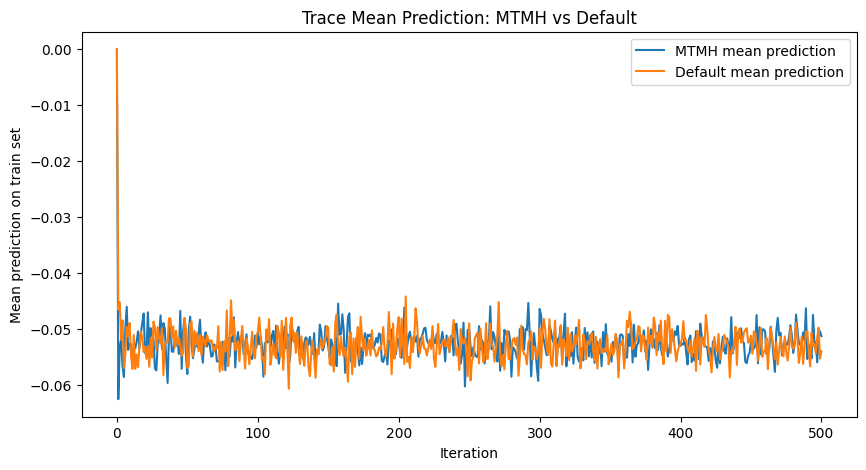

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(means_mtmh, label='MTMH mean prediction')
plt.plot(means_default, label='Default mean prediction')
plt.xlabel('Iteration')
plt.ylabel('Mean prediction on train set')
plt.legend()
plt.title('Trace Mean Prediction: MTMH vs Default')
plt.show()

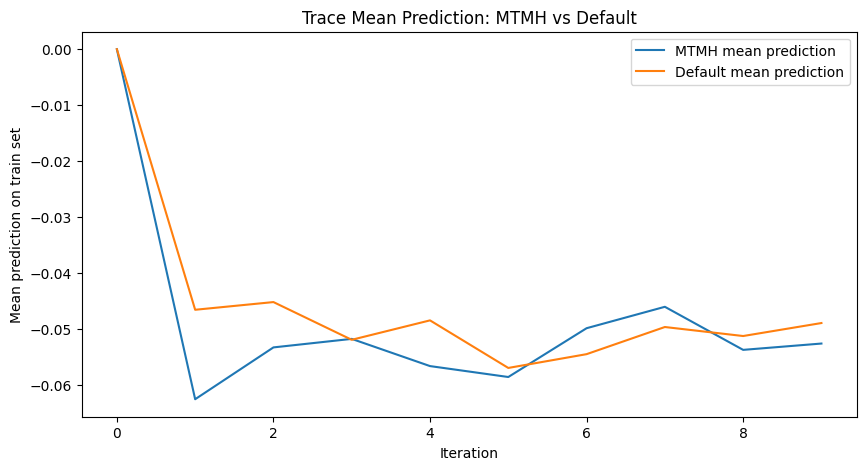

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(means_mtmh[:10], label='MTMH mean prediction')
plt.plot(means_default[:10], label='Default mean prediction')
plt.xlabel('Iteration')
plt.ylabel('Mean prediction on train set')
plt.legend()
plt.title('Trace Mean Prediction: MTMH vs Default')
plt.show()

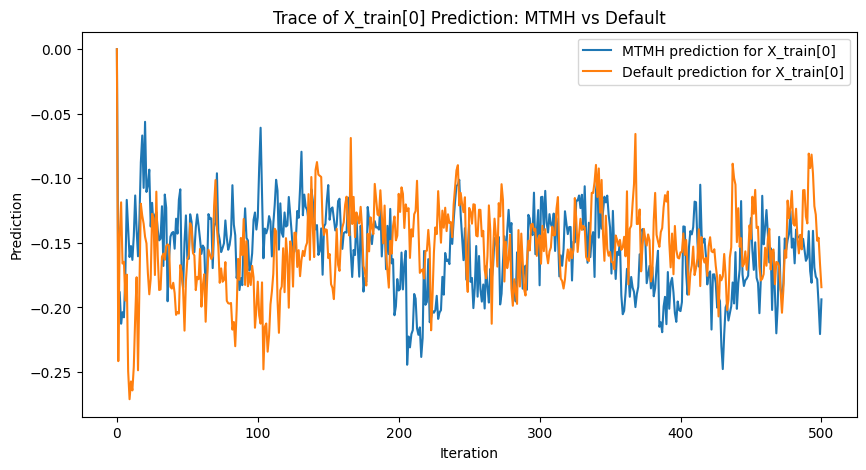

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(first_preds_mtmh, label='MTMH prediction for X_train[0]', color='tab:blue')
plt.plot(first_preds_default, label='Default prediction for X_train[0]', color='tab:orange')
plt.xlabel('Iteration')
plt.ylabel('Prediction')
plt.legend()
plt.title('Trace of X_train[0] Prediction: MTMH vs Default')
plt.show()